# The Variational Autoencoder

## Limitations of autoencoders for content generation

Question is “what is the link between autoencoders and content generation?”. Indeed, once the autoencoder has been trained, we have both an encoder and a decoder but still no real way to produce any new content. At first sight, we could be tempted to think that, if the latent space is regular enough (well “organized” by the encoder during the training process), we could take a point randomly from that latent space and decode it to get a new content. The decoder would then act more or less like the generator of a Generative Adversarial Network. 

While autoencoders are well-suited to de-noising, compression, and decompression tasks, they do not perform well as generative models. Variational autoencoders (VAEs), introduced by [Kingma and Welling (2017)](https://arxiv.org/pdf/1906.02691.pdf), are designed to overcome the weaknesses of autoencoders as generative models and are one of the most commonly-used methods for music generation. [Briot, Hadjerest, and Pachet (2019)](https://arxiv.org/pdf/1709.01620.pdf) identify four different music-generation systems that are built on VAEs: [MusicVAE](https://magenta.tensorflow.org/music-vae), [VRAE](https://arxiv.org/pdf/1412.6581v6.pdf), [VRASH](https://arxiv.org/pdf/1705.05458.pdf), and [GSLR-VAE](https://arxiv.org/pdf/1707.04588.pdf).

The autoencoder is solely trained to encode and decode with as few loss as possible, no matter how the latent space is organised. Thus, if we are not careful about the definition of the architecture, it is natural that, during the training, the network takes advantage of any overfitting possibilities to achieve its task as well as it can… unless we explicitly regularise it.

## Definition of Variational Autoencoder

So, in order to be able to use the decoder of our autoencoder for generative purpose, we have to be sure that the latent space is regular enough. One possible solution to obtain such regularity is to introduce explicit regularisation during the training process. 

A __variational autoencoder__ can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

Just as a standard autoencoder, a variational autoencoder is an architecture composed of both an encoder and a decoder and that is trained to minimize the reconstruction error between the encoded-decoded data and the initial data. 
The model is then trained as follows:

<ul>
    <li> the input is encoded as distribution over the latent space </li>
    <li> a point from the latent space is sampled from that distribution </li>
    <li> the sampled point is decoded and the reconstruction error can be computed </li>
    <li> the reconstruction error is backpropagated through the network </li>
</ul>

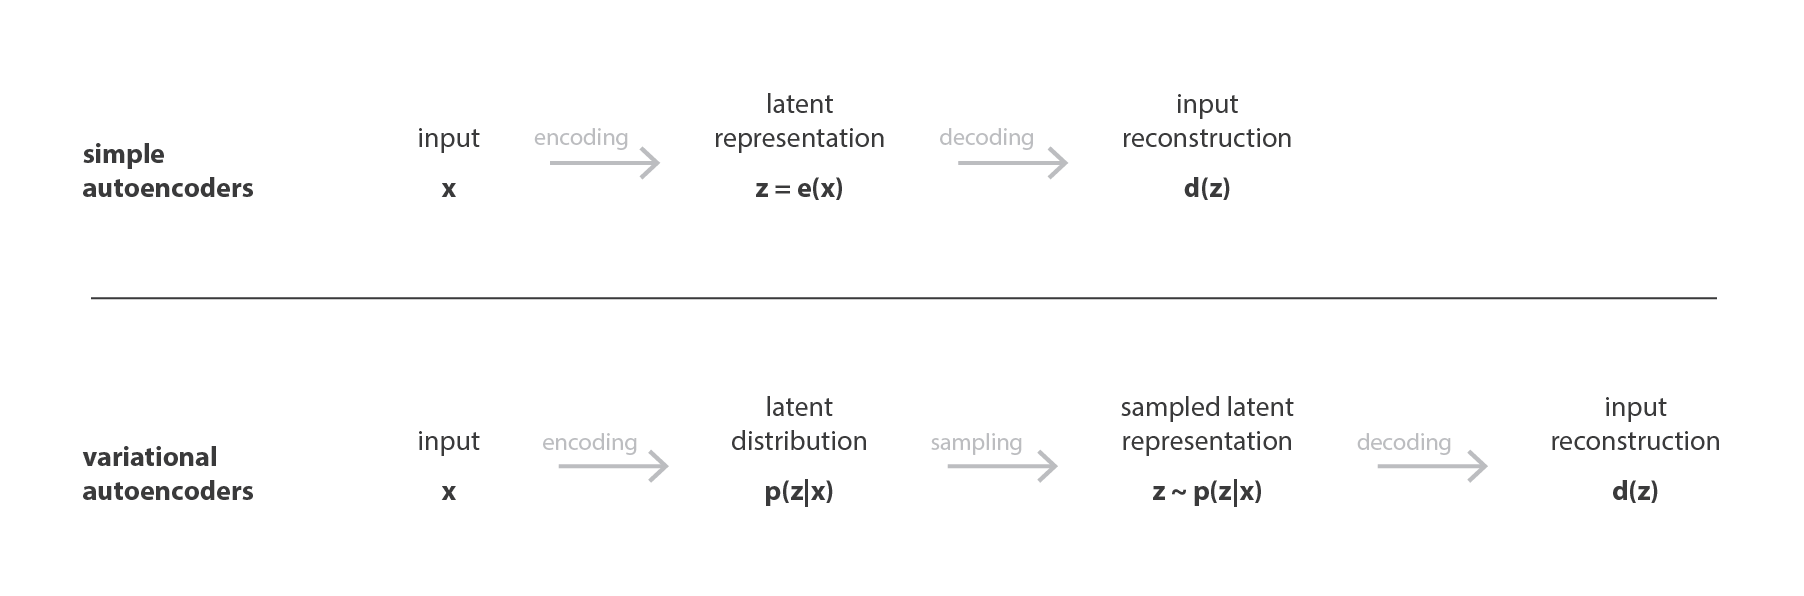

The reason why an input is encoded as a distribution with some variance instead of a single point is that it makes possible to express very naturally the latent space regularisation: the distributions returned by the encoder are enforced to be close to a standard normal distribution. This way ensures both a local and global regularisation of the latent space (local because of the variance control and global because of the mean control).

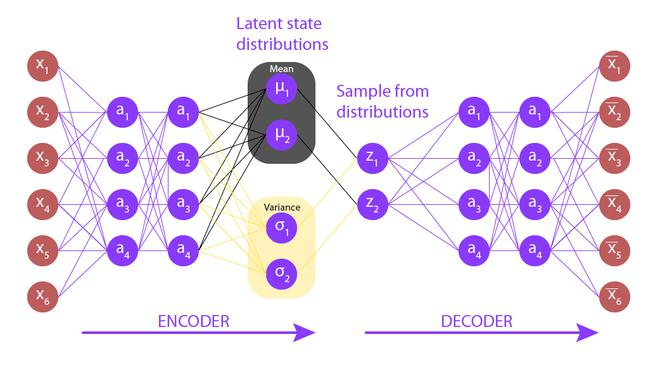

## Kullback - Leibler divergence

The loss function that is minimized when training a VAE is composed of a “reconstruction term” (on the final layer), that tends to make the encoding-decoding scheme as performant as possible, and a “regularisation term” (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. That regularisation term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian.

In mathematical statistics, __the Kullback–Leibler divergence__ $D_{KL}$ (also called __relative entropy__),
is a measure of how one probability distribution is different from a second, reference probability distribution. In other words KL divergence helps us to measure just how much information we lose when we choose an approximation. 

KL Divergence has its origins in information theory. The primary goal of information theory is to quantify how much information is in data. The most important metric in information theory is called Entropy, typically denoted as H. The definition of Entropy for a probability distribution is

$H = -\sum_{i=1}^N p(x_i)log p(x)$

The key thing with Entropy is that, simply knowing the theoretical lower bound on the number of bits we need, we have a way to quantify exactly how much information is in our data. Now that we can quantify this, we want to quantify how much information is lost when we substitute our observed distribution for a parameterized approximation.

### Measuring information lost using Kullback - Leibler Divergence

Kullback-Leibler Divergence is just a slight modification of our formula for entropy. Rather than just having our probability distribution $p$ we add in our approximating distribution $q$. Then we look at the difference of the log values for each:

$D_{KL}(p||q) = \sum_{i=1}{N} p(x_i) \cdot(log p(x_i) - log q(x_i))$ 

Essentially, what we're looking at with the KL divergence is the expectation of the log difference between the probability of data in the original distribution with the approximating distribution. If we think in terms of $log_2$ we can interpret this as "how many bits of information we expect to lose". We could rewrite our formula in terms of expectation:

$D_{KL}(p||q) = E[log p(x) - log q(x)]$

The more common way to see KL divergence written is as follows:

$D_{KL}(p||q) = \sum_{i=1}^{N} p(x_i) \cdot log\frac{p(x_i)}{q(x_i)}$

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import music21

from music21 import *
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

np.random.seed(42)

In [2]:
# Define save directory
save_dir = './datasets/'

# Identify list of MIDI files
song_list = os.listdir(save_dir)

streams = []
# Load and make list of stream objects
for song in song_list:
    stream = converter.parse(save_dir+song)
    streams.append(stream)

In [3]:
len(streams)

389

## Preparing for encoding

In [4]:
# Define function to test whether stream is monophonic
def monophonic(stream):
    try:
        length = len(instrument.partitionByInstrument(stream).parts)
    except:
        length = 0
    return length == 1

In [6]:
# Merge notes into chords
original_scores = [stream.chordify() for stream in streams if monophonic(stream)]

In [7]:
# Define empty lists of lists
original_chords = [[] for _ in original_scores]
original_durations = [[] for _ in original_scores]
original_keys = []

# Extract notes, chords, durations, and keys
for i, song in enumerate(original_scores):
    original_keys.append(str(song.analyze('key')))
    for element in song:
        if isinstance(element, note.Note):
            original_chords[i].append(element.pitch)
            original_durations[i].append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):
            original_chords[i].append('.'.join(str(pitch) for pitch in element.pitches))
            original_durations[i].append(element.duration.quarterLength)

In [9]:
# Map unique chords to integers
unique_chords = np.unique([chord for chords in original_chords for chord in chords])
chord_to_int = dict(zip(unique_chords, list(range(0, len(unique_chords)))))

# Map unique durations to integers
unique_durations = np.unique([duration for durations in original_durations for duration in durations])
duration_to_int = dict(zip(unique_durations, list(range(0, len(unique_durations)))))

In [10]:
len(unique_chords)

1462

In [11]:
len(unique_durations)

17

In [12]:
# Invert chord and duration dictionaries
int_to_chord = {i: c for c, i in chord_to_int.items()}
int_to_duration = {i: c for c, i in duration_to_int.items()}

In [13]:
# Define sequence length
sequence_length = 32

# Define empty arrays for train data
train_chords = []
train_durations = []

# Construct training sequences for chords and durations
for s in range(len(original_chords)):
    chord_list = [chord_to_int[chord] for chord in original_chords[s]]
    duration_list = [duration_to_int[duration] for duration in original_durations[s]]
    for i in range(len(chord_list) - sequence_length):
        train_chords.append(chord_list[i:i+sequence_length])
        train_durations.append(duration_list[i:i+sequence_length])

In [14]:
len(train_chords)

10795

In [16]:
# Define number of samples, chords and notes, and input dimension
n_samples = train_chords.shape[0]
n_chords = train_chords.shape[1]
input_dim = n_chords * sequence_length

# Set number of latent features
latent_dim = 2

In [17]:
# Flatten sequence of chords into single dimension
train_chords_flat = train_chords.reshape(n_samples, input_dim)

We can make the first change by replacing the latent state vector in the autoencoder with three layers:
<ol>
    <li> A mean layer </li>
    <li> A (log) variance layer </li>
    <li> A sampling layer </li>
</ol>

Each set of inputs maps to a single mean and the natural logarithm of the variance, which is sufficient to characterize a normal distribution. The model then randomly draws points from the distribution in the sampling layer.

The code block below defines a function that can be used to create a __sampling__ layer. It takes a mean and log variance as inputs. It then uses the random submodule of tensorflow to draw a tensor of points, epsilon, from a standard normal distribution, which has both a mean and a log variance of 0. We next want to transform these draws into draws from distributions characterized by the mean and log_var parameters. To do this, we need to first scale the draws, epsilon, by the standard deviations of the associated distributions. We can compute these standard deviations by dividing log_var by 2 and then exponentiating it. We then add the distribution means, mean.

In [18]:
# Define function to generate sampling layer.
def sampling(params):
    mean, log_var = params
    batch_size = tf.shape(mean)[0]
    latent_dim = tf.shape(mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim))
    return mean + tf.exp(log_var / 2.0) * epsilon

We can now modify the autoencoder model to incorporate the mean, log_var, and sampling layers. Notice that the encoded layer now takes two inputs and the encoder layer has three outputs.

In [19]:
# Define the input and latent layer shapes.
encoder_input = tf.keras.layers.Input(shape = (input_dim))
latent = tf.keras.layers.Input(shape = (latent_dim))

In [20]:
# Add mean and log variance layers.
mean = tf.keras.layers.Dense(latent_dim)(encoder_input)
log_var = tf.keras.layers.Dense(latent_dim)(encoder_input)

In [21]:
# Add sampling layer.
encoded = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([mean, log_var])

In [22]:
# Define decoder layer.
decoded = tf.keras.layers.Dense(input_dim, activation = 'sigmoid')(latent)

In [23]:
# Define encoder layers.
encoder = tf.keras.Model(encoder_input, [mean, log_var, encoded], name = 'encoder')

In [24]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46784)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            93570       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            93570       input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2)            0           dense[0][0]                      
                                                                 dense_1[0][0]              

In [25]:
# Define decoder layers.
decoder = tf.keras.Model(latent, decoded, name = 'decoder')

In [26]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46784)             140352    
Total params: 140,352
Trainable params: 140,352
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Define variational autoencoder model.
vae = tf.keras.Model(encoder_input, decoder(encoded), name = 'vae')

In [29]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46784)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            93570       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            93570       input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2)            0           dense[0][0]                      
                                                                 dense_1[0][0]                  

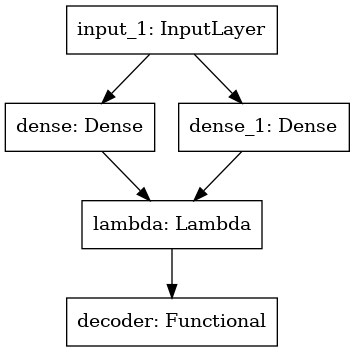

In [30]:
keras.utils.plot_model(vae, to_file="vae.png", show_shapes=False)

As was the case with the autoencoder model, our latent state is the output of the encoded layer. There is, however, an important difference: instead of mapping each set of inputs to a single latent state, we use the sampling layer to map them to random values drawn from a normal distribution with parameters mean and log_var. This means that the same input will be associated with a distribution of latent states.

The final step is to adjust the loss function to place discipline on the model's choice of mean and log_var values. In particular, we will compute the [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between each distribution defined by the mean and log_var layers, and the standard normal distribution, which has a mean and log variance of 0. The further our means and log variances are away from 0, the higher the KL divergence loss component will be.

A natural question is why we would want to force each distribution to be close to a standard normal. The reason we do this is that we want to sample latent states and use them to generate music. If we apply the KL divergence penalty to the loss function, this will allow us to use independent draws from a standard normal distribution to obtain latent states that are likely to generate high quality pieces of music.

In the code block below, we show how to modify the loss function to incorporate the KL divergence term. The first component of the loss function is the binary crossentropy loss, computed on the inputs to and outputs from the vae model. This is also what we used for the autoencoder. It is called a __"reconstruction loss"__ because it penalizes us for failing to reconstruct the original song. The KL term is the mean KL divergence between the latent space distributions and the standard normal distribution. We combine the two to compute the total loss, vae_loss, add that to the model, compile, and then train.

In [31]:
# Define the reconstruction loss.
reconstruction_loss = tf.keras.losses.binary_crossentropy(vae.inputs[0], vae.outputs[0])

In [32]:
# Define the Kullback-Liebler divergence term.
kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var), axis = -1)

In [33]:
# Combine the reconstruction and KL loss terms.
vae_loss = reconstruction_loss + kl_loss

In [34]:
# Add the loss to the model.
vae.add_loss(vae_loss)

In [35]:
# Compile the model.
vae.compile(optimizer='rmsprop')

In [36]:
batch_size = 30
epochs = 150

In [37]:
# Train the model.
history = vae.fit(train_chords_flat, batch_size = batch_size, validation_split = 0.33, epochs = epochs, verbose = 1)

Epoch 1/150
242/242 [==============================] - 127s 520ms/step - loss: 0.6328 - val_loss: 0.5775
Epoch 2/150
242/242 [==============================] - 10s 40ms/step - loss: 0.5278 - val_loss: 0.4797
Epoch 3/150
242/242 [==============================] - 10s 43ms/step - loss: 0.4362 - val_loss: 0.3955
Epoch 4/150
242/242 [==============================] - 9s 38ms/step - loss: 0.3586 - val_loss: 0.3239
Epoch 5/150
242/242 [==============================] - 9s 38ms/step - loss: 0.2926 - val_loss: 0.2632
Epoch 6/150
242/242 [==============================] - 9s 38ms/step - loss: 0.2374 - val_loss: 0.2135
Epoch 7/150
242/242 [==============================] - 9s 38ms/step - loss: 0.1919 - val_loss: 0.1721
Epoch 8/150
242/242 [==============================] - 9s 38ms/step - loss: 0.1547 - val_loss: 0.1385
Epoch 9/150
242/242 [==============================] - 9s 38ms/step - loss: 0.1242 - val_loss: 0.1113
Epoch 10/150
242/242 [==============================] - 9s 38ms/step - loss: 

In [39]:
encoder.save('models/vae_encoder.h5')

In [40]:
decoder.save('models/vae_decoder.h5')

In [38]:
vae.save('models/vae.h5')

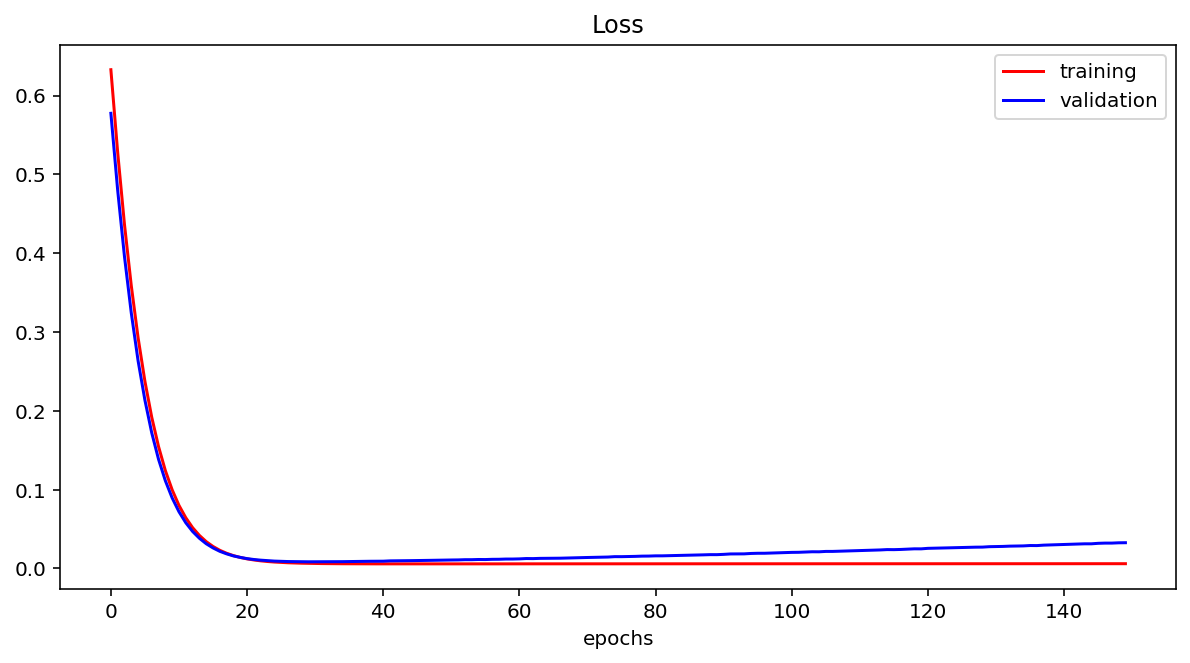

In [42]:
plt.figure(figsize=(10, 5))
plt.title('Loss')
loss = history.history['loss']
plt.plot(range(epochs), loss, color='red', label='training')
val_loss = history.history['val_loss']
plt.plot(range(epochs), val_loss, color='blue', label='validation')
plt.xlabel('epochs')
plt.legend(loc='best')
    
plt.show()

In [39]:
#from tensorflow.keras.models import load_model
#load_model('./models/vae.h5')

Finally, we move to music generation. We draw a random latent vector from the standard normal distribution, pass it to the decoder, reshape the output, and take the argmax of each column. This will return a sequence of 32 integers, which correspond to notes and chords, which we next identify using the intToChord dictionary. We then define a stream object, append guitar as the instrument, add the sequence of notes and chords to the stream, and then export it as a MIDI file.

In [43]:
# Generate integers from randomly drawn latent state.
generated_chords = decoder(np.random.normal(size=(1,latent_dim))).numpy().reshape(n_chords, batch_size).argmax(0)

In [44]:
# Identify chords associated with integers.
chord_sequence = [int_to_chord[c] for c in generated_chords]

In [46]:
# Initialize stream with guitar as instrument.
generated_stream = music21.stream.Stream()
generated_stream.append(instrument.Guitar())

In [47]:
# Append notes and chords and export to MIDI file
for j in range(len(chord_sequence)):
    try:
        generated_stream.append(note.Note(chord_sequence[j].replace('.', ' ')))
    except:
        generated_stream.append(chord.Chord(chord_sequence[j].replace('.', ' ')))

generated_stream.write('midi', fp='./generated/vae.mid')

'./generated/vae.mid'

In [48]:
# Play midi file
def play_midi(filename):
    mf = midi.MidiFile()
    mf.open(filename)
    mf.read()
    mf.close()
    stream = midi.translate.midiFileToStream(mf)
    stream.show('midi')

In [49]:
play_midi('./generated/vae.mid')